In [1]:
# Minimal Reproducable Example to check errors
import numpy as np
import h5py
import hdf5plugin
import matplotlib.pyplot as plt

In [2]:
def mass_function(mass, volume, bins, range=None, poisson_uncert=False,
                  return_edges=False, **kwargs):

    if "normed" in kwargs:
        kwargs["normed"] = False
        log.warn("Turned off normed kwarg in mass_function()")

    if (range is not None and (bins in ['blocks',
                                        'knuth', 'knuths',
                                        'scott', 'scotts',
                                        'freedman', 'freedmans'])):
        mass = mass[(mass >= range[0]) & (mass <= range[1])]

    if isinstance(bins, str):
        log.info("Calculating bin widths using `%s' method..." % bins)
        if bins in ['blocks']:
            bins = bayesian_blocks(mass)
        elif bins in ['knuth', 'knuths']:
            dm, bins = knuth_bin_width(mass, True)
        elif bins in ['scott', 'scotts']:
            dm, bins = scotts_bin_width(mass, True)
        elif bins in ['freedman', 'freedmans']:
            dm, bins = freedman_bin_width(mass, True)
        else:
            raise ValueError("unrecognized bin code: '%s'" % bins)
        log.info("...done")

    vals, edges = np.histogram(mass, bins, range, **kwargs)
    width = edges[1]-edges[0]
    radius = width/2.0
    centers = edges[:-1]+radius
    if poisson_uncert:
        uncert = np.sqrt(vals.astype(float))

    vals = vals.astype(float) / (volume * width)

    if not poisson_uncert:
        mf = np.dstack((centers, vals)).squeeze()
    else:
        uncert /= (volume * width)
        mf = np.dstack((centers, vals, uncert)).squeeze()

    if not return_edges:
        return mf
    else:
        return mf, edges

In [3]:
## GALAXIES IN HALOES SO NEED GALAXY STELLAR MASS
# get the name of Subfind halo catalog
subhalos  = '/home/jovyan/Data/FOF_Subfind/IllustrisTNG/CV/CV_0/fof_subhalo_tab_026.hdf5'
# read halo catalogue
subh = h5py.File(subhalos, 'r')
subh.keys()

<KeysViewHDF5 ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']>

In [4]:
## CV_0/snap_026.hdf5
# Need to use PartType4 Masses for STELLAR Mass, not Halo mass
snap_stars  = '/home/jovyan/Data/Sims/IllustrisTNG/CV/CV_0/snap_026.hdf5'
data = h5py.File(snap_stars, 'r')
BoxSize      = data['Header'].attrs[u'BoxSize']/1e3    #size of the snapshot in comoving Mpc/h
redshift     = data['Header'].attrs[u'Redshift']       #reshift of the snapshot
V = BoxSize**3 
print('Box size:                 %.2f Mpc/h'%BoxSize)
print('snapshot redshift:        %.2f'%redshift)
print('Volume %.2f Mpc^3'%V)

Box size:                 25.00 Mpc/h
snapshot redshift:        0.40
Volume 15625.00 Mpc^3


In [5]:
# The units of stellar masses ouput by the model are 1e10 Msol.  Let's convert
# this to log10(M/Msol).
# the mass of all star particles associated with a subhalo, is given by SubhaloMassType
mass_sol = subh['Subhalo/SubhaloMassType'][:]
mass_sol

array([[4.58408356e+02, 3.71254077e+03, 0.00000000e+00, 0.00000000e+00,
        3.32005348e+01, 2.27090687e-01],
       [1.55289415e-02, 1.25998182e+01, 0.00000000e+00, 0.00000000e+00,
        7.13820601e+00, 5.18528186e-02],
       [2.13028240e+00, 3.20769806e+01, 0.00000000e+00, 0.00000000e+00,
        1.49825788e+00, 7.66853802e-03],
       ...,
       [0.00000000e+00, 1.62201568e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.62201568e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.68689638e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]], dtype=float32)

In [6]:
mass_sol_nonzero = mass_sol[mass_sol > 0]
mass_sol_nonzero = np.log(mass_sol_nonzero*1e10)
mass_sol_nonzero

array([29.153612, 31.245323, 26.528418, ..., 21.206936, 21.206936,
       21.246157], dtype=float32)

In [7]:
mass_min, mass_max = mass_sol_nonzero.min(), mass_sol_nonzero.max()
mass_range = [mass_min, mass_max]
print('Mass Range: ',mass_range)

Mass Range:  [14.383627, 31.245323]


In [8]:
mf = mass_function(mass_sol_nonzero, V, bins=50, range=mass_range)
                         #range=(7.5, 11.5))


In [9]:
smf_normalized = mf / V
smf_normalized

array([[9.31343628e-04, 1.21458855e-08],
       [9.52926514e-04, 1.21458855e-08],
       [9.74509521e-04, 1.33604740e-07],
       [9.96092529e-04, 2.07694642e-06],
       [1.01767554e-03, 1.05061909e-05],
       [1.03925854e-03, 8.86649640e-06],
       [1.06084143e-03, 1.13078194e-05],
       [1.08242444e-03, 1.33483281e-05],
       [1.10400745e-03, 6.68023702e-06],
       [1.12559033e-03, 6.42517342e-06],
       [1.14717334e-03, 5.28346019e-06],
       [1.16875635e-03, 4.85835419e-06],
       [1.19033923e-03, 5.61139909e-06],
       [1.21192224e-03, 5.04054248e-06],
       [1.23350525e-03, 5.21058487e-06],
       [1.25508813e-03, 5.96362977e-06],
       [1.27667114e-03, 6.81384176e-06],
       [1.29825415e-03, 7.84624202e-06],
       [1.31983716e-03, 9.60739542e-06],
       [1.34142004e-03, 2.34172672e-05],
       [1.36300305e-03, 5.09155520e-05],
       [1.38458606e-03, 4.73325157e-05],
       [1.40616895e-03, 3.46886489e-05],
       [1.42775195e-03, 2.61015079e-05],
       [1.449334

/tmp/ipykernel_4400/1878631714.py:7: RuntimeWarning: divide by zero encountered in log
  ax.plot(smf_normalized[:, 0], np.log(smf_normalized[:,1]), color="RoyalBlue", lw=3,
/tmp/ipykernel_4400/1878631714.py:17: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')  # Apply logarithmic scale to the y-axis as well


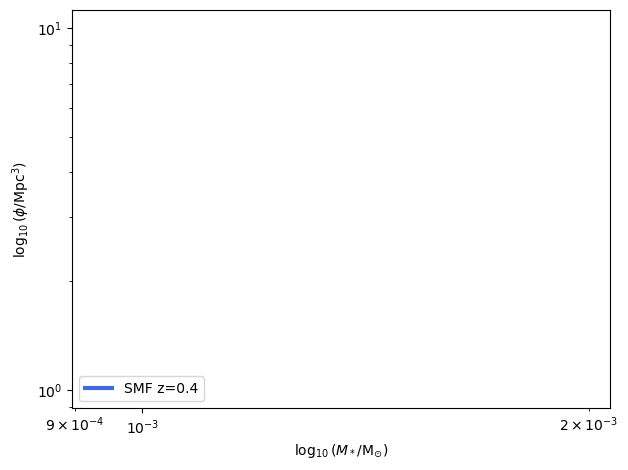

In [10]:

# Now let's plot the mass function...

# Create a new figure (with 1 column and 1 row) and axis
fig, ax = plt.subplots(1, 1)

# Plot the mass function
ax.plot(smf_normalized[:, 0], np.log(smf_normalized[:,1]), color="RoyalBlue", lw=3,
        label="SMF z=0.4")

# Set the axis labels.
# Note the use of LaTeX here.
ax.set_xlabel(r"$\log_{10}(M_* / {\rm M_{\odot}})$")
ax.set_ylabel(r"$\log_{10}(\phi / {\rm Mpc^3})$")

# Apply logarithmic scale to both x and y axes
ax.set_xscale('log')
ax.set_yscale('log')  # Apply logarithmic scale to the y-axis as well


# Add the legend
ax.legend(loc="lower left")

# Finally save the figure as a PDF
plt.tight_layout()